In [2]:
# Cell 1: Install dependencies
%pip install ultralytics
%pip install pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


CUDA available: True
CUDA device count: 1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# Cell 2: Import libraries
import os
import shutil
import random
from PIL import Image
from ultralytics import YOLO
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from PIL import Image, ImageOps
import pandas as pd
from IPython.display import display
import seaborn as sns

# EDA

In [6]:
# Cell 3: Define paths
root = r"C:\Users\desai\OneDrive\Desktop\Manu\OPIXray"

train_img_dir = os.path.join(root, "train", "train_image")
train_lbl_dir = os.path.join(root, "train", "train_annotation")
test_img_dir = os.path.join(root, "test", "test_image")
test_lbl_dir = os.path.join(root, "test", "test_annotation")

In [7]:
# Load image and label paths
from pathlib import Path

train_img_dir = Path(train_img_dir)
train_lbl_dir = Path(train_lbl_dir)

train_images = list(train_img_dir.glob("*.jpg"))
train_labels = list(train_lbl_dir.glob("*.txt"))

In [8]:
sampled_images = random.sample(train_images, min(50, len(train_images)))
shapes = []
for img_path in sampled_images:
    img = cv2.imread(str(img_path))
    if img is not None:
        shapes.append(img.shape)

shapes_df = pd.DataFrame(shapes, columns=["Height", "Width", "Channels"])
display(shapes_df.describe())

,Height,Width,Channels
count,50.0,50.0,50.0
mean,954.0,1225.0,3.0
std,0.0,0.0,0.0
min,954.0,1225.0,3.0
25%,954.0,1225.0,3.0
50%,954.0,1225.0,3.0
75%,954.0,1225.0,3.0
max,954.0,1225.0,3.0


In [9]:
# Count weapon types from annotation files
class_counts = Counter()
for label_path in train_labels:
    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                weapon_type = parts[1]
                class_counts[weapon_type] += 1

# Create DataFrame
counts_df = pd.DataFrame(class_counts.items(), columns=["Weapon_Type", "Count"])
display(counts_df)

,Weapon_Type,Count
0,Straight_Knife,1429
1,Folding_Knife,2767
2,Scissor,2629
3,Utility_Knife,2877
4,Multi-tool_Knife,2815


C:\Users\desai\AppData\Local\Temp\ipykernel_18680\2423691953.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_df.sort_values("Count", ascending=False),


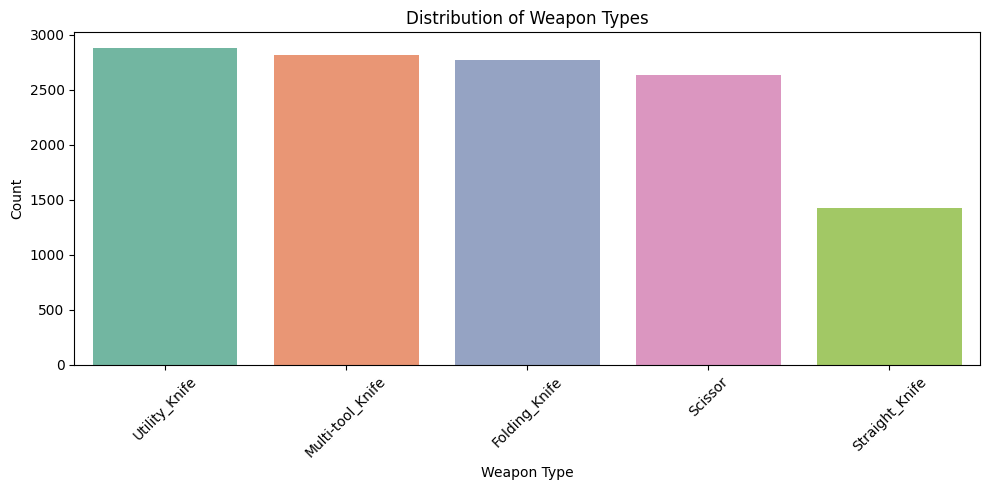

In [11]:
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=counts_df.sort_values("Count", ascending=False),
            x="Weapon_Type", y="Count", palette="Set2")
plt.title("Distribution of Weapon Types")
plt.xlabel("Weapon Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

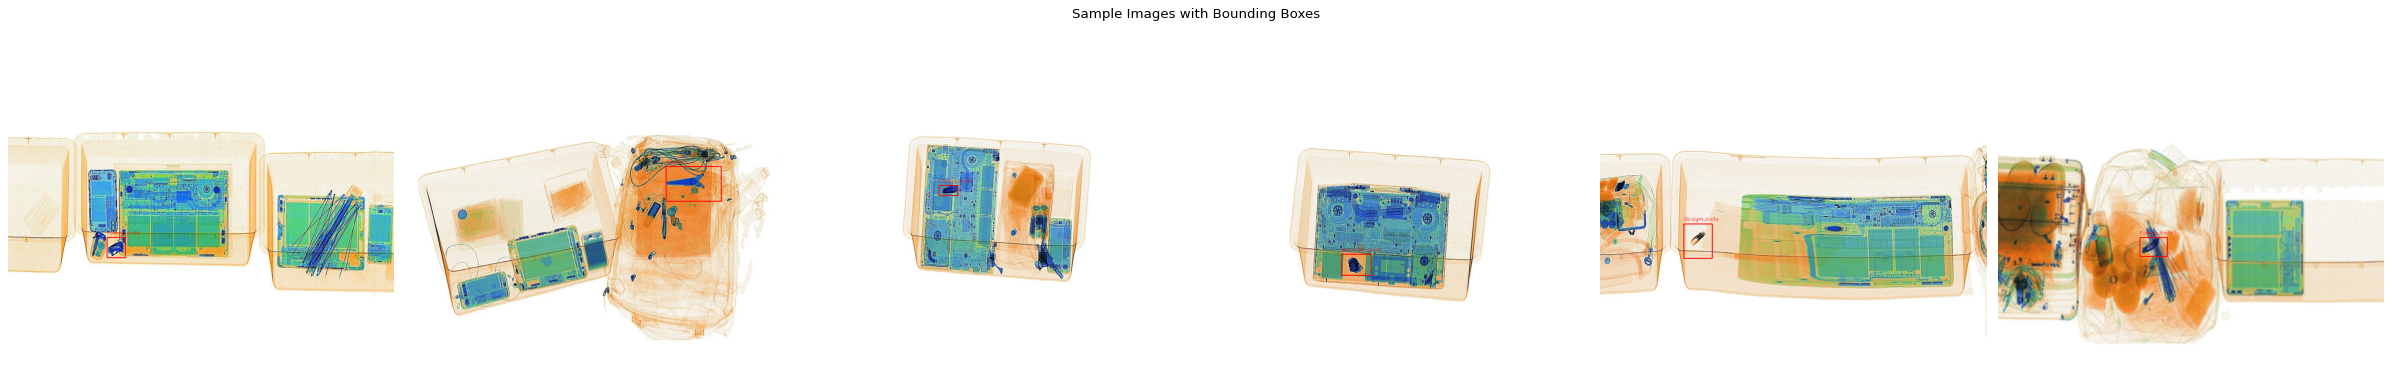

In [12]:
# -------------------------------
# 3. Show images with bounding boxes (custom annotation format)
# -------------------------------
sample_size = min(6, len(train_images))
fig, axs = plt.subplots(1, sample_size, figsize=(5 * sample_size, 5), dpi=80)
if sample_size == 1:
    axs = [axs]

for ax, img_path in zip(axs, random.sample(train_images, sample_size)):
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    label_path = train_lbl_dir / (img_path.stem + ".txt")
    if label_path.exists():
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    x1, y1, x2, y2 = map(int, parts[2:6])
                    label = parts[1]
                    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img_rgb, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    ax.imshow(img_rgb)
    ax.axis("off")

plt.suptitle("Sample Images with Bounding Boxes")
plt.tight_layout()
plt.show()
plt.close('all')


In [13]:
import os
import cv2
import random
import shutil
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm

# Original data paths
train_img_dir = Path(root) / "train" / "train_image"
train_lbl_dir = Path(root) / "train" / "train_annotation"

# Load images
train_images = list(train_img_dir.glob("*.jpg"))

# Hue and blur probabilities
HUE_PROB = 0.4
BLUR_PROB = 0.35

# Helpers
def change_hue(img, factor=1.5):
    converter = ImageEnhance.Color(img)
    return converter.enhance(factor)

def apply_blur(img, radius=2):
    return img.filter(ImageFilter.GaussianBlur(radius))

# Augment and save into original folders with suffixes
for img_path in tqdm(train_images, desc="Augmenting"):
    img = Image.open(img_path).convert("RGB")
    base_name = img_path.stem

    # Corresponding label
    lbl_path = train_lbl_dir / f"{base_name}.txt"
    if not lbl_path.exists():
        continue

    # Hue augmentation
    if random.random() < HUE_PROB:
        hue_img = change_hue(img, factor=random.uniform(1.3, 1.7))
        hue_filename = f"{base_name}_hue.jpg"
        hue_img.save(train_img_dir / hue_filename)
        shutil.copy(lbl_path, train_lbl_dir / hue_filename.replace(".jpg", ".txt"))

    # Blur augmentation
    if random.random() < BLUR_PROB:
        blur_img = apply_blur(img, radius=random.uniform(1.5, 2.5))
        blur_filename = f"{base_name}_blur.jpg"
        blur_img.save(train_img_dir / blur_filename)
        shutil.copy(lbl_path, train_lbl_dir / blur_filename.replace(".jpg", ".txt"))

print("✅ Augmentation complete. Files added to original training dataset.")


Augmenting:   6%|▋         | 782/12471 [00:15<03:55, 49.56it/s]


KeyboardInterrupt: 

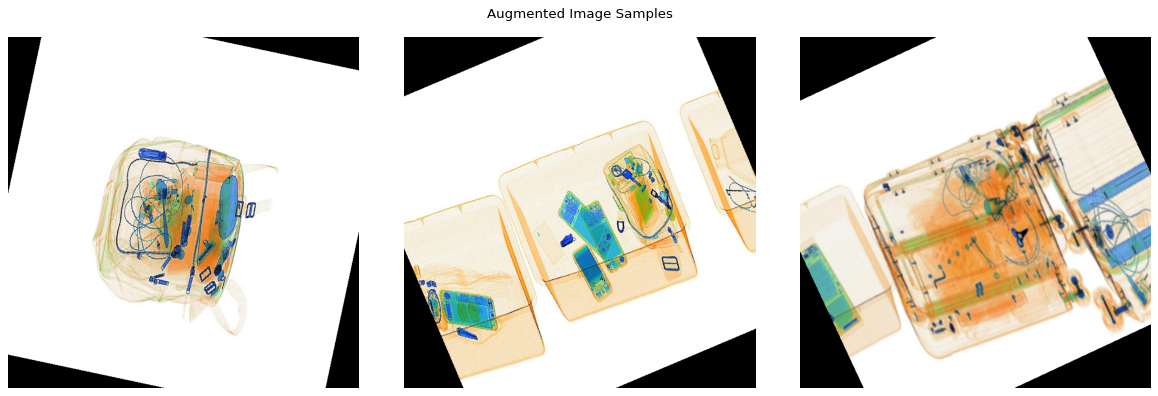

In [14]:
# -------------------------------
# 4. Show augmented image samples
# -------------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
for ax, img_path in zip(axs, random.sample(train_images, min(3, len(train_images)))):
    image = Image.open(img_path).convert("RGB")
    image = image.resize((640, 640))
    if random.random() > 0.5:
        image = ImageOps.mirror(image)
    angle = random.randint(-30, 30)
    image = image.rotate(angle)
    ax.imshow(np.array(image))
    ax.axis("off")

plt.suptitle("Augmented Image Samples")
plt.tight_layout()
plt.show()
plt.close('all')

In [15]:
yolo_base_dir = os.path.join(root, "yolov8")
os.makedirs(yolo_base_dir, exist_ok=True)

dataset_dirs = {
    'images': {
        'train': os.path.join(yolo_base_dir, 'train', 'images'),
        'val': os.path.join(yolo_base_dir, 'val', 'images'),
    },
    'labels': {
        'train': os.path.join(yolo_base_dir, 'train', 'labels'),
        'val': os.path.join(yolo_base_dir, 'val', 'labels'),
    }
}

for category in dataset_dirs:
    for split in dataset_dirs[category]:
        os.makedirs(dataset_dirs[category][split], exist_ok=True)


In [16]:
def convert_to_yolo_format(img_path, label_line):
    """Convert label from original format to YOLO format."""
    parts = label_line.strip().split()
    
    if len(parts) == 6:
        _, weapon_type, x1, y1, x2, y2 = parts
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    else:
        print(f"Unexpected label format: {label_line}")
        return None

    # Use the correct weapon mapping
    weapon_classes = {
        'Multi-tool_Knife': 0,
        'Folding_Knife': 1,
        'Straight_Knife': 2,
        'Utility_Knife': 3,
        'Scissor': 4
    }

    if weapon_type not in weapon_classes:
        print(f"Unrecognized weapon type: {weapon_type}")
        return None

    class_id = weapon_classes[weapon_type]

    # Get image dimensions
    image = Image.open(img_path)
    w, h = image.size

    # Convert to YOLO format (normalized x_center, y_center, width, height)
    x_center = ((x1 + x2) / 2) / w
    y_center = ((y1 + y2) / 2) / h
    width = (x2 - x1) / w
    height = (y2 - y1) / h

    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"


# # Cell 4: Label format conversion
# def convert_to_yolo_format(img_path, label_line):
#     parts = label_line.strip().split()
    
#     if len(parts) == 6:
#         _, knife_type, x1, y1, x2, y2 = parts
#         x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
#     else:
#         print(f"Unexpected label format: {label_line}")
#         return None

#     knife_classes = {
#     'Multi-tool_Knife': 0,
#     'Folding_Knife': 1,
#     'Straight_Knife': 2,
#     'Utility_Knife': 3,
#     'Scissor': 4
#     }


#     class_id = 0
#     for knife_name, id_value in knife_classes.items():
#         if knife_name in knife_type.lower():
#             class_id = id_value
#             break

#     image = Image.open(img_path)
#     w, h = image.size

#     x_center = ((x1 + x2) / 2) / w
#     y_center = ((y1 + y2) / 2) / h
#     width = (x2 - x1) / w
#     height = (y2 - y1) / h

#     return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"


In [17]:
# Cell 5: Dataset processing
def process_dataset():
    orig_img_dir = train_img_dir
    orig_lbl_dir = train_lbl_dir
    converted = 0
    skipped = 0
    all_images = []

    for file in os.listdir(orig_img_dir):
        if not file.endswith('.jpg'):
            continue

        img_path = os.path.join(orig_img_dir, file)
        lbl_path = os.path.join(orig_lbl_dir, file.replace('.jpg', '.txt'))

        if not os.path.exists(lbl_path):
            print(f"Missing label for {file}, skipping...")
            skipped += 1
            continue

        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                print(f"Empty label in {file}, skipping...")
                skipped += 1
                continue

        yolo_labels = []
        for line in lines:
            line = line.strip()
            if line:
                yolo_label = convert_to_yolo_format(img_path, line)
                yolo_labels.append(yolo_label)
        
        if yolo_labels:
            all_images.append(file)
            temp_label_path = os.path.join(yolo_base_dir, file.replace('.jpg', '.txt'))
            with open(temp_label_path, 'w') as f:
                f.write('\n'.join(yolo_labels))

            temp_img_path = os.path.join(yolo_base_dir, file)
            shutil.copy(img_path, temp_img_path)
            converted += 1

    print(f"✅ Converted: {converted} | ❌ Skipped: {skipped}")
    return all_images


In [18]:
# Cell 6: Train/val split
def create_train_val_split(all_images, train_ratio=0.8):
    random.shuffle(all_images)
    split_idx = int(train_ratio * len(all_images))
    train_files = all_images[:split_idx]
    val_files = all_images[split_idx:]

    for file_list, split in [(train_files, 'train'), (val_files, 'val')]:
        for file in file_list:
            src_img = os.path.join(yolo_base_dir, file)
            dst_img = os.path.join(dataset_dirs['images'][split], file)
            shutil.copy(src_img, dst_img)

            label_file = file.replace('.jpg', '.txt')
            src_lbl = os.path.join(yolo_base_dir, label_file)
            dst_lbl = os.path.join(dataset_dirs['labels'][split], label_file)
            shutil.copy(src_lbl, dst_lbl)

    print(f"✅ Train files: {len(train_files)}")
    print(f"✅ Val files: {len(val_files)}")


In [19]:
# Cell 7: YAML config
def create_yaml():
    yaml_dir = os.path.join(yolo_base_dir, 'data')
    os.makedirs(yaml_dir, exist_ok=True)

    yaml_content = f"""
path: {yolo_base_dir}
train: train/images
val: val/images

nc: 5
names: ['Multi-tool_Knife', 'Folding_Knife', 'Straight_Knife', 'Utility_Knife', 'Scissor']
    """
    yaml_path = os.path.join(yaml_dir, 'opixray.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content.strip())

    print(f"✅ YAML configuration created at {yaml_path}")
    return yaml_path


In [20]:
# Cell 8: Cleanup temp files
def cleanup_temp_files():
    for file in os.listdir(yolo_base_dir):
        if file.endswith(('.jpg', '.txt')) and os.path.isfile(os.path.join(yolo_base_dir, file)):
            os.remove(os.path.join(yolo_base_dir, file))


In [21]:
# Cell 9: Model training
def train_model(yaml_path, epochs=30, img_size=640, batch_size=16):
    print("Starting YOLOv8 training...")
    model = YOLO('yolov8s.pt')
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        patience=5,
        name='opixray_yolov8',
        device='cuda'  # ✅ Use NVIDIA GPU
    )
    print("✅ Training complete.")
    return model


In [22]:
# Cell 10: Model validation
def validate_model(model):
    val_results = model.val()
    print("✅ Validation completed")
    return val_results


In [23]:
# Cell 11: Save best model
def save_full_model(model_dir='runs/detect/opixray_yolov8/weights', save_as='saved_models/best_opixray.pt'):
    os.makedirs(os.path.dirname(save_as), exist_ok=True)
    src_path = os.path.join(model_dir, 'best.pt')
    if os.path.exists(src_path):
        shutil.copy(src_path, save_as)
        print(f"✅ Model saved to: {save_as}")
    else:
        print("❌ best.pt not found.")


In [24]:
# Cell 12: Run full pipeline
print("🚀 Starting YOLOv8 X-Ray Knife Detection pipeline")

print("\n1️⃣ Processing dataset...")
all_images = process_dataset()

print("\n2️⃣ Creating train/val split...")
create_train_val_split(all_images, train_ratio=0.8)

print("\n3️⃣ Creating YAML config...")
yaml_path = create_yaml()

print("\n4️⃣ Cleaning up temp files...")
cleanup_temp_files()

print("\n5️⃣ Training model...")
model = train_model(yaml_path)

print("\n6️⃣ Validating model...")
val_results = validate_model(model)

print("\n7️⃣ Saving best model...")
save_full_model()


🚀 Starting YOLOv8 X-Ray Knife Detection pipeline

1️⃣ Processing dataset...
✅ Converted: 12952 | ❌ Skipped: 0

2️⃣ Creating train/val split...
✅ Train files: 10361
✅ Val files: 2591

3️⃣ Creating YAML config...
✅ YAML configuration created at C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\data\opixray.yaml

4️⃣ Cleaning up temp files...

5️⃣ Training model...
Starting YOLOv8 training...
Ultralytics 8.3.128  Python-3.12.7 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\data\opixray.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, for

train: Scanning C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\train\labels... 12653 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12653/12653 [00:04<00:00, 2965.98it/s]


train: New cache created: C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\train\labels.cache
val: Fast image access  (ping: 0.40.3 ms, read: 194.8100.4 MB/s, size: 176.7 KB)


val: Scanning C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\val\labels... 6808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6808/6808 [00:02<00:00, 2834.46it/s]


val: New cache created: C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\val\labels.cache
Plotting labels to runs\detect\opixray_yolov86\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\opixray_yolov86
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.62G      2.125       2.74      1.648         21        640: 100%|██████████| 791/791 [04:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:04<00:00,  3.31it/s]

                   all       6808       6831      0.513      0.526      0.431      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.58G      1.951      1.691      1.574         22        640: 100%|██████████| 791/791 [03:43<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.534      0.532      0.471      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G      1.927      1.589      1.574         27        640: 100%|██████████| 791/791 [03:43<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.551      0.533      0.481      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.97G      1.889      1.504      1.558         21        640: 100%|██████████| 791/791 [03:33<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.563      0.646      0.523      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.97G      1.856       1.43      1.542         20        640: 100%|██████████| 791/791 [03:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.38it/s]

                   all       6808       6831        0.6      0.616      0.548      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.97G      1.843      1.358      1.533         23        640: 100%|██████████| 791/791 [03:35<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.577      0.608      0.517      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.97G       1.82      1.308      1.516         28        640: 100%|██████████| 791/791 [03:35<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.41it/s]

                   all       6808       6831      0.602      0.633      0.544      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         4G      1.806      1.269      1.505         20        640: 100%|██████████| 791/791 [03:39<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.41it/s]

                   all       6808       6831      0.653      0.667      0.581       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.57G      1.787      1.219      1.493         16        640: 100%|██████████| 791/791 [03:34<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.41it/s]

                   all       6808       6831      0.655      0.658      0.586      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.95G      1.777      1.184      1.495         26        640: 100%|██████████| 791/791 [03:35<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.37it/s]

                   all       6808       6831      0.664      0.697        0.6      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G      1.757      1.176      1.484         28        640: 100%|██████████| 791/791 [03:37<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:04<00:00,  3.28it/s]

                   all       6808       6831      0.678      0.729      0.625      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G      1.738      1.153      1.471         21        640: 100%|██████████| 791/791 [03:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.38it/s]

                   all       6808       6831      0.686      0.728      0.628      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.99G      1.728      1.124      1.467         19        640: 100%|██████████| 791/791 [03:30<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.679      0.743      0.633      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.99G      1.724      1.093      1.464         19        640: 100%|██████████| 791/791 [03:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:05<00:00,  3.23it/s]

                   all       6808       6831      0.684      0.743      0.632      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.99G      1.716      1.087       1.46         20        640: 100%|██████████| 791/791 [03:37<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.34it/s]

                   all       6808       6831      0.686      0.746      0.648       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.99G        1.7      1.052       1.44         27        640: 100%|██████████| 791/791 [03:41<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.34it/s]

                   all       6808       6831      0.682      0.751      0.641      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.99G      1.682      1.036      1.433         27        640: 100%|██████████| 791/791 [03:37<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:04<00:00,  3.32it/s]

                   all       6808       6831      0.693      0.754      0.651      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.99G      1.663      1.014      1.422         18        640: 100%|██████████| 791/791 [03:39<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.38it/s]

                   all       6808       6831      0.701      0.768      0.659      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.99G      1.647     0.9852      1.421         20        640: 100%|██████████| 791/791 [03:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:04<00:00,  3.28it/s]

                   all       6808       6831      0.699      0.777      0.658      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.99G      1.638      0.974      1.413         21        640: 100%|██████████| 791/791 [03:39<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:13<00:00,  2.90it/s]

                   all       6808       6831      0.699       0.78      0.664      0.357


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.99G      1.613     0.8637      1.512         13        640: 100%|██████████| 791/791 [05:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:18<00:00,  2.72it/s]

                   all       6808       6831      0.709      0.791      0.668      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.99G      1.595     0.8437      1.501         13        640: 100%|██████████| 791/791 [04:02<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.39it/s]

                   all       6808       6831      0.711      0.794      0.669       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.99G      1.566     0.8176      1.486         14        640: 100%|██████████| 791/791 [03:39<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.34it/s]

                   all       6808       6831      0.713        0.8      0.676       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.99G      1.548     0.7878      1.469         13        640: 100%|██████████| 791/791 [03:33<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.37it/s]

                   all       6808       6831      0.715      0.805      0.681      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.99G      1.516     0.7701      1.452         13        640: 100%|██████████| 791/791 [03:38<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.42it/s]

                   all       6808       6831      0.719      0.806      0.683        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.99G      1.486     0.7519      1.432         12        640: 100%|██████████| 791/791 [03:38<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]

                   all       6808       6831      0.721      0.813      0.688      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.99G      1.461     0.7323      1.424         13        640: 100%|██████████| 791/791 [03:41<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:01<00:00,  3.44it/s]

                   all       6808       6831      0.721      0.813      0.692      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.99G      1.432     0.7123      1.398         13        640: 100%|██████████| 791/791 [03:38<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:02<00:00,  3.41it/s]

                   all       6808       6831      0.728      0.813      0.693      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.99G      1.399     0.6899      1.378         13        640: 100%|██████████| 791/791 [03:39<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:03<00:00,  3.38it/s]

                   all       6808       6831      0.726      0.818      0.697      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.99G      1.374     0.6777      1.361         13        640: 100%|██████████| 791/791 [03:38<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:04<00:00,  3.28it/s]

                   all       6808       6831      0.729      0.816      0.697      0.438



30 epochs completed in 2.400 hours.
Optimizer stripped from runs\detect\opixray_yolov86\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\opixray_yolov86\weights\best.pt, 22.5MB

Validating runs\detect\opixray_yolov86\weights\best.pt...
Ultralytics 8.3.128  Python-3.12.7 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 213/213 [01:08<00:00,  3.09it/s]


                   all       6808       6831       0.73      0.816      0.697      0.438
      Multi-tool_Knife       2685       2693      0.972      0.533      0.775      0.462
         Folding_Knife       1483       1484      0.651       0.63      0.582      0.348
        Straight_Knife        619        619      0.689      0.961      0.738      0.459
         Utility_Knife       1051       1052      0.651      0.962      0.699      0.453
               Scissor        980        983      0.687      0.993      0.693      0.466
Speed: 0.2ms preprocess, 6.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\opixray_yolov86
✅ Training complete.

6️⃣ Validating model...
Ultralytics 8.3.128  Python-3.12.7 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1655.4785.6 MB/s, size: 276.9 KB)


val: Scanning C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\val\labels.cache... 6808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6808/6808 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 426/426 [01:33<00:00,  4.55it/s]


                   all       6808       6831       0.73      0.816      0.697      0.438
      Multi-tool_Knife       2685       2693      0.971      0.533      0.776      0.462
         Folding_Knife       1483       1484      0.651       0.63      0.581      0.349
        Straight_Knife        619        619       0.69      0.961      0.738       0.46
         Utility_Knife       1051       1052      0.651      0.962      0.699      0.453
               Scissor        980        983      0.687      0.993      0.693      0.466
Speed: 0.3ms preprocess, 10.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\opixray_yolov862
✅ Validation completed

7️⃣ Saving best model...
✅ Model saved to: saved_models/best_opixray.pt


In [26]:
# Cell 13: Run inference
print("\n🔍 Running prediction on one validation image...")
#sample_img = os.path.join(dataset_dirs['images']['val'], os.listdir(dataset_dirs['images']['val'])[0])

#sample_img = r"C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\train\images\009046.jpg"
sample_img = r"C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\train\images\009069_blur.jpg"
results = model.predict(source=sample_img, save=True)


🔍 Running prediction on one validation image...

image 1/1 C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\yolov8\train\images\009069_blur.jpg: 512x640 1 Straight_Knife, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs\detect\opixray_yolov864


In [28]:
# Reload your saved model
from ultralytics import YOLO
model_saved = YOLO(r'C:\Users\desai\OneDrive\Desktop\Manu\OPIXray\runs\detect\opixray_yolov85\weights\best.pt')

# Run prediction with visualization
results = model_saved.predict(
    source=r"C:\Users\desai\Downloads\manu\mana.jpg",
    show=True,   # Shows bounding boxes in a pop-up window
    save=True    # Saves the image with bounding boxes to disk
)



image 1/1 C:\Users\desai\Downloads\manu\mana.jpg: 512x640 1 kitchen_knife, 25.8ms
Speed: 4.3ms preprocess, 25.8ms inference, 5.6ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs\detect\predict3


In [25]:
print(model_saved.names)

{0: 'kitchen_knife', 1: 'utility_knife', 2: 'pocket_knife', 3: 'hunting_knife', 4: 'switchblade'}


In [26]:
from ultralytics import YOLO

# Reload saved model
model_test = YOLO('saved_models/best_opixray.pt')

# Manually assign your classes
model_test.names = ['kitchen_knife', 'utility_knife', 'pocket_knife', 'hunting_knife', 'switchblade']

# Run prediction
results = model_test.predict(
    source=r"C:\Users\desai\Downloads\manu\mana.jpg",
    show=True,
    save=True
)


AttributeError: can't set attribute 'names'